# Part 1

## Load Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import re
import time
import datetime

from fractions import Fraction
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer # used in next cell
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4') # open multilingual wordnet
nltk.download('wordnet')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
test_url = 'https://raw.githubusercontent.com/mmojan/JSC270-A4/main/Corona_NLP_test.csv'
test_df = pd.read_csv(test_url, encoding = 'latin1')
train_url = 'https://raw.githubusercontent.com/mmojan/JSC270-A4/main/Corona_NLP_train.csv'
train_df = pd.read_csv(train_url, encoding = 'latin1')

We check if there are any observations with missing labels or sentiment scores that are strings.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
test_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [ ]:
train_df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

### Remove Observations w. Missing Labels or Sentiment Scores that are Strings

There are no observations with missing labels

In [ ]:
# sentiment scores that are strings
train_df["Sentiment"].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [ ]:
train_df.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
test_df.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [ ]:
test_df["Sentiment"].unique()

array(['Extremely Negative', 'Positive', 'Extremely Positive', 'Negative',
       'Neutral'], dtype=object)

### Convert Sentiment to Number Encoding
We replace Extremely Negative and Negative sentiments to 0, Neutral to 1, and Positive and Extremely Positive to 2.

In [ ]:
replace_values = {'Extremely Negative': 0, 'Positive':2,'Extremely Positive':2, 'Negative':0, 'Neutral':1}
train_df = train_df.replace(to_replace=replace_values)
test_df = test_df.replace(to_replace=replace_values)

## A: Proportion of Sentiments

Consider the training data. What is the balance between the three classes? In other words, what proportion of the observations (in the training set) belong to each class?

In [ ]:
sentiment_counts = train_df.groupby("Sentiment").count()["UserName"]
total = train_df.Sentiment.count()

In [ ]:
print(f"{sentiment_counts[0]} {sentiment_counts[1]} {sentiment_counts[2]}")

15398 7713 18046


In [ ]:
# proportions
print(f"{sentiment_counts[0]/total} {sentiment_counts[1]/total} {sentiment_counts[2]/total}")

0.37412833782831595 0.18740432976164442 0.4384673324100396


## B: Tokenize Tweets

Tokenize the tweets. In other words, for each observation, convert the tweet from a single string of running text into a list of individual tokens (possibly with punctuation), splitting on whitespace. The result should be that each observation (tweet) is a list of individual tokens.

In [ ]:
def tokenize(df, column):
  # df['tokens'] = df[column].apply(nltk.word_tokenize)

  df['tokens'] = df[column].str.split()
tokenize(train_df, 'OriginalTweet')
tokenize(test_df, 'OriginalTweet')
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,tokens
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,"[@MeNyrbie, @Phil_Gahan, @Chrisitv, https://t...."
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,2,"[advice, Talk, to, your, neighbours, family, t..."
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,2,"[Coronavirus, Australia:, Woolworths, to, give..."
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,2,"[My, food, stock, is, not, the, only, one, whi..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0,"[Me,, ready, to, go, at, supermarket, during, ..."
...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,1,"[Airline, pilots, offering, to, stock, superma..."
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,0,"[Response, to, complaint, not, provided, citin..."
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,2,"[You, know, itÂs, getting, tough, when, @Kame..."
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,1,"[Is, it, wrong, that, the, smell, of, hand, sa..."


## C: Remove URL Tokens

Using a regular expression, remove any URL tokens from each of the observations. Hint: In this dataset, all such tokens begin with “http”.

In [ ]:
def remove_url(df):
  for tokens in df['tokens']:
    for token in tokens:
      if re.match('http', token) is not None:
        tokens.remove(token)
remove_url(train_df)
remove_url(test_df)
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,tokens
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,"[@MeNyrbie, @Phil_Gahan, @Chrisitv, and, and]"
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,2,"[advice, Talk, to, your, neighbours, family, t..."
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,2,"[Coronavirus, Australia:, Woolworths, to, give..."
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,2,"[My, food, stock, is, not, the, only, one, whi..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0,"[Me,, ready, to, go, at, supermarket, during, ..."
...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,1,"[Airline, pilots, offering, to, stock, superma..."
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,0,"[Response, to, complaint, not, provided, citin..."
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,2,"[You, know, itÂs, getting, tough, when, @Kame..."
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,1,"[Is, it, wrong, that, the, smell, of, hand, sa..."


## D: Remove Punctuation & Convert to Lowercase

Remove all punctuation (,.?!;:’") and special characters(@, #, +, &, =, $, etc). Also, convert all tokens to lowercase only. Can you think of a scenario when you might want to keep some forms of punctuation?

In [ ]:
def convert_lowercase(df):
  '''
  Convert tokens into lowercase

  df: dataframe
  '''
  lowercase_tokens = []
  for row in df['tokens']:
    lowercase_tokens.append([t.lower() for t in row])
  df['tokens'] = lowercase_tokens

In [ ]:
def remove_punctuation(df):
  '''
  Remove punctuation and special characters from tokens
  '''
  tokens_no_punct = []
  for row in df['tokens']:
    tokens_no_punct.append([re.sub('[^\w\s]','', t) for t in row])
  df['tokens'] = tokens_no_punct

In [ ]:
def remove_whitespace(df):
  for tokens in df['tokens']:
    for w in tokens:
      if (re.match('', w)) is not None:
        tokens.remove(w)

In [ ]:
convert_lowercase(train_df)
remove_punctuation(train_df)
convert_lowercase(test_df)
remove_punctuation(test_df)
train_df["tokens"][0]

['menyrbie', 'phil_gahan', 'chrisitv', 'and', 'and']

## E: Stem Tokens

Now stem your tokens. This will have the effect of converting similar word forms into identical tokens (e.g. run, runs, running → run). Please specify which stemmer you use.

In [ ]:
def stem_tokens(df):
  stemmed_tokens =  []
  stemmer = PorterStemmer()
  for tokens in df["tokens"]:
    stemmed_tokens.append([stemmer.stem(w) for w in tokens])
  df["tokens"] = stemmed_tokens

In [ ]:
stem_tokens(train_df)
stem_tokens(test_df)
train_df["tokens"][0]

['menyrbi', 'phil_gahan', 'chrisitv', 'and', 'and']

## F: Remove Stopwords

Lastly, remove stopwords. Using the english stopwords list from nltk, remove these common words from your observations. This list is very long (I think almost 200 words), so remove only the first 100 stopwords in the list.

In [ ]:
def remove_stopwords(df):
  sw = stopwords.words('english')[:100]
  tokens_no_sw = []
  for row in df['tokens']:
    tokens_no_sw.append([w for w in row if w not in sw])
  df['tokens'] = tokens_no_sw

In [ ]:
remove_stopwords(train_df)
remove_stopwords(test_df)
train_df["tokens"]

0                          [menyrbi, phil_gahan, chrisitv]
1        [advic, talk, neighbour, famili, exchang, phon...
2        [coronaviru, australia, woolworth, give, elder...
3        [food, stock, not, onli, one, empti, pleas, do...
4        [readi, go, supermarket, dure, covid19, outbre...
                               ...                        
41152    [airlin, pilot, offer, stock, supermarket, she...
41153    [respons, complaint, not, provid, cite, covid1...
41154    [know, itâ, get, tough, when, kameronwild, rat...
41155    [wrong, smell, hand, sanit, start, turn, coron...
41156    [tartiicat, well, newus, rift, s, go, 70000, a...
Name: tokens, Length: 41157, dtype: object

## G: Convert to Vectors

In [ ]:
def override_fcn(doc):
  return doc

In [ ]:
count_vec = CountVectorizer(
  analyzer='word',
  tokenizer= override_fcn,
  preprocessor= override_fcn,
  token_pattern= None,
  max_features = 1000)

def convert_to_counts(df):
  counts = count_vec.fit_transform(df['tokens'].to_numpy())
  return counts.toarray()


In [ ]:
train_counts= convert_to_counts(train_df)
test_counts = convert_to_counts(test_df)

In [ ]:
train_counts

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
print(f"length: {len(train_counts)}, {len(train_counts[0])}")

length: 41157, 1000


## H: Fit Naive Bayes Model

In [ ]:
X_train = train_counts
X_test = test_counts
y_train = train_df["Sentiment"]
y_test = test_df["Sentiment"]

In [ ]:
# It has 41157 rows: Each row is a tweet
# It has 1000 columns: Each column is a word
# So, X_train[i][j] is the number of times the word with the index j appears in the tweet i
X_train.shape

(41157, 1000)

In [ ]:
total_words_tweets = X_train.sum()

In [ ]:
# Fit Naive Bayes model to training data
nb = MultinomialNB() # Naive Bayes Model
nb.fit(X_train, y_train)

# Predict on test data
y_preds = nb.predict(X_test)
y_preds_train = nb.predict(X_train)

print('Test accuracy with simple Naive Bayes on training data:',accuracy_score(y_train,y_preds_train))
print('Test accuracy with simple Naive Bayes on testing data:',accuracy_score(y_test,y_preds))

Test accuracy with simple Naive Bayes on training data: 0.6782321354812061
Test accuracy with simple Naive Bayes on testing data: 0.38388625592417064


In [ ]:
def get_word_count(counts_arr, index):
  '''
  Return word count for dataset
  '''
  return counts_arr[:][index].sum()

def get_word_prob(counts_arr, index):
  '''
  Return word probability for dataset
  '''
  return (counts_arr[:][index].sum())/total_words_tweets


def get_word_count_for_class(counts_arr, indices, index):
  '''
  Return word count for class
  '''
  count = 0
  for doc_i in range(len(counts_arr)):
    if doc_i in indices:
      count += counts_arr[doc_i][index]
  return count
def get_indices_for_class(df, c):
  return df.index[df['Sentiment'] == c].tolist()

In [ ]:
# this method needs a "text" or the original non-tokenized, cleaned text
def get_top_n_words(text, n=None):
    vec = CountVectorizer().fit(text)
    counts = vec.transform(text)
    sum_words = counts.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
train_df.head(1)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,tokens,TweetCopy,CleanedTweet,tokens_joined
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,"[menyrbi, phil_gahan, chrisitv]",@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,menyrbi phil_gahan chrisitv


In [ ]:
train_df["tokens"]

0                          [menyrbi, phil_gahan, chrisitv]
1        [advic, talk, neighbour, famili, exchang, phon...
2        [coronaviru, australia, woolworth, give, elder...
3        [food, stock, not, onli, one, empti, plea, don...
4        [readi, go, supermarket, dure, covid19, outbre...
                               ...                        
41152    [airlin, pilot, offer, stock, supermarket, she...
41153    [respons, complaint, not, provid, cite, covid1...
41154    [know, itâ, get, tough, when, kameronwild, rat...
41155    [wrong, smell, hand, sanit, start, turn, coron...
41156    [tartiicat, well, newus, rift, s, go, 70000, a...
Name: tokens, Length: 41157, dtype: object

In [ ]:
train_df["tokens_joined"] = [" ".join(tokens) for tokens in train_df["tokens"]]

In [ ]:
train_df["tokens_joined"]

0                              menyrbi phil_gahan chrisitv
1        advic talk neighbour famili exchang phone numb...
2        coronaviru australia woolworth give elderli di...
3        food stock not onli one empti plea dont panic ...
4        readi go supermarket dure covid19 outbreak not...
                               ...                        
41152    airlin pilot offer stock supermarket shelv nz ...
41153    respons complaint not provid cite covid19 rela...
41154    know itâ get tough when kameronwild ration toi...
41155    wrong smell hand sanit start turn coronaviru c...
41156    tartiicat well newus rift s go 70000 amazon rn...
Name: tokens_joined, Length: 41157, dtype: object

In [ ]:
get_top_n_words(train_df[train_df["Sentiment"]==0]["tokens_joined"], 5)

[('coronaviru', 6703),
 ('covid19', 4862),
 ('price', 4332),
 ('food', 3623),
 ('thi', 3206)]

In [ ]:
get_top_n_words(train_df[train_df["Sentiment"]==1]["tokens_joined"], 5)

[('coronaviru', 3792),
 ('covid19', 2752),
 ('store', 1581),
 ('supermarket', 1436),
 ('price', 1361)]

In [ ]:
get_top_n_words(train_df[train_df["Sentiment"]==2]["tokens_joined"], 5)

[('coronaviru', 7467),
 ('covid19', 6003),
 ('store', 3896),
 ('thi', 3772),
 ('price', 3323)]

(array([15398.,     0.,     0.,     0.,     0.,  7713.,     0.,     0.,
            0., 18046.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

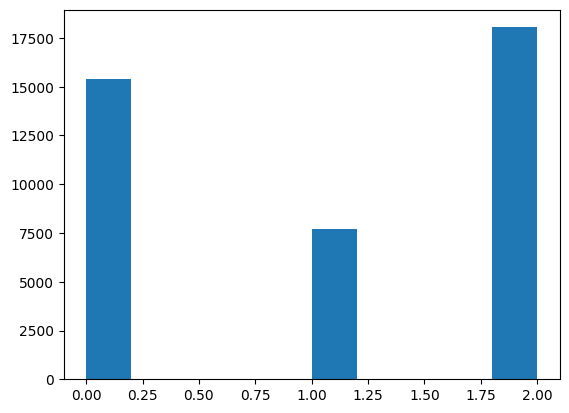

In [ ]:
# check if these numbers make sense given the distribution of the data
plt.hist(train_df.Sentiment)

In [ ]:
# Log probabilities  of features (words) for each class (sentiment)
log_prob_arr = nb.feature_log_prob_
print(f"# of classes: {len(log_prob_arr)}\n# of words: {len(log_prob_arr[0])}")

# of classes: 3
# of words: 1000


In [ ]:
# Probabilities of class 0
prob_arr_0 = np.exp(log_prob_arr[0])

In [ ]:
top_five = sorted(prob_arr_0, reverse = True)[:5]
top_five

[0.027269768955418137,
 0.01978115847705826,
 0.017625284738040994,
 0.014920273348519364,
 0.01474129515131794]

In [ ]:
for word in count_vec.get_feature_names_out():
  word_index = count_vec.vocabulary_[word]
  word_prob = get_word_prob(X_train, word_index)
  if (word_prob in top_five):
    print(word)

In [ ]:
# Find 5 most probable words in each class
def most_prob(c):
  log_prob_arr = nb.feature_log_prob_
  prob_arr = np.exp(log_prob_arr[c])
  top_five = np.argsort(prob_arr)[:5]
  word_lst = []
  for word in count_vec.get_feature_names_out():
    if (count_vec.vocabulary_[word] in top_five):
      word_lst.append(word)
  return word_lst
lst0 = most_prob(0)
lst1 = most_prob(1)
lst2 = most_prob(2)
lst0

['amount', 'arent', 'hell', 'weve', 'wont']

In [ ]:
for word in lst0:
  print(word)
  print(get_word_count_for_class(X_train, get_indices_for_class(train_df, 0), count_vec.vocabulary_[word]))

amount
14
arent
22
hell
14
weve
18
wont
22


## I: ROC Curve Appropriate?

## J: G-H with TF-IDF vectors

In [ ]:
def convert_to_tfidf(counts):
  tfidf = TfidfTransformer()
  tfs = tfidf.fit_transform(counts)
  return tfs.toarray()

In [ ]:
train_counts= convert_to_counts(train_df)
test_counts = convert_to_counts(test_df)
train_vectors = convert_to_tfidf(train_counts)
test_vectors = convert_to_tfidf(test_counts)

In [ ]:
np.shape(train_vectors)

(41157, 1000)

In [ ]:
train_vectors

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12988842, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
np.shape(train_counts)

(41157, 1000)

In [ ]:
# Fit Naive Bayes model to training data
nb = MultinomialNB()
nb.fit(train_vectors, y_train)

# Predict on test data
y_preds = nb.predict(test_vectors)
y_preds_train = nb.predict(train_vectors)

print('Test accuracy with simple Naive Bayes on training data:',accuracy_score(y_train,y_preds_train))
print('Test accuracy with simple Naive Bayes on testing data:',accuracy_score(y_test,y_preds))

Test accuracy with simple Naive Bayes on training data: 0.663945379886775
Test accuracy with simple Naive Bayes on testing data: 0.40705634544497105


## K: E-H using TF-IDF vectors

In [ ]:
def lemmatize(df):
  lemm_tokens =  []
  lemmatizer = WordNetLemmatizer()
  for tokens in df["tokens"]:
    lemm_tokens.append([lemmatizer.lemmatize(t) for t in tokens])
  df["tokens"] = lemm_tokens

In [ ]:
# Part E: Stem Tokens
lemmatize(train_df)
lemmatize(test_df)

In [ ]:
train_counts = convert_to_counts(train_df)
test_counts = convert_to_counts(test_df)

In [ ]:
# Part G: Convert to Vectors
train_vectors = convert_to_tfidf(train_counts)
test_vectors = convert_to_tfidf(test_counts)

In [ ]:
# Fit Naive Bayes model to training data
nb = MultinomialNB()
nb.fit(train_vectors, y_train)

# Predict on test data
y_preds = nb.predict(test_vectors)
y_preds_train = nb.predict(train_vectors)

print('Test accuracy with simple Naive Bayes on training data:',accuracy_score(y_train,y_preds_train))
print('Test accuracy with simple Naive Bayes on testing data:',accuracy_score(y_test,y_preds))

Test accuracy with simple Naive Bayes on training data: 0.6640911631071263
Test accuracy with simple Naive Bayes on testing data: 0.41363875724065297


# Part 2

## Load Data

In [ ]:
df2_url = 'https://raw.githubusercontent.com/mmojan/JSC270-A4/main/tweets.csv'
df2 = pd.read_csv(df2_url, encoding = 'latin1')

In [ ]:
# Delete unnamed column
df2.drop("Unnamed: 0", axis=1, inplace=True)
df2.head(2)

,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count
0,The priority for the city should be on providi...,0,2023-03-27 21:01:36+00:00,0,10194,EmergencyAgent,1145
1,"Like it or not, this kind of clip is the sort ...",0,2023-03-27 21:01:26+00:00,0,2843,EDenhoff,4630


In [ ]:
# Useful function for EDA
def get_min_max(lst):
  '''
  Returns min and max value of column with numerical values
  '''
  return lst.min(), lst.max()

## New Variables

### Sentiment Analysis

First, let's create a new feature "Sentiment" based on tweet text

Earlier, we trained our own Naive Bayes model to do so. However, the accuracy of our model was not amazing. Here, we use a pretrained model from the NLTK package: NLTK VADER

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import operator
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
# df2["sentiment_positive"] = df2["tweet_text"].apply(lambda x: sia.polarity_scores(x)["pos"])
# df2["sentiment_neutral"] = df2["tweet_text"].apply(lambda x: sia.polarity_scores(x)["neu"])
# df2["sentiment_negative"] = df2["tweet_text"].apply(lambda x: sia.polarity_scores(x)["neg"])
df2["sentiment_score"] = df2["tweet_text"].apply(lambda x: sia.polarity_scores(x)["compound"])
df2["sentiment"] = np.select([df2["sentiment_score"] < 0, df2["sentiment_score"] == 0, df2["sentiment_score"] > 0],
                           ['0', '1', '2'])
df2

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count,sentiment_score,sentiment
0,The priority for the city should be on providi...,0,2023-03-27 21:01:36+00:00,0,10194,EmergencyAgent,1145,0.0000,1
1,"Like it or not, this kind of clip is the sort ...",0,2023-03-27 21:01:26+00:00,0,2843,EDenhoff,4630,-0.2500,0
2,On a scale of moderately conservative (1) to r...,0,2023-03-27 21:01:16+00:00,0,13608,dzoolander85,11234,0.0000,1
3,Keep up with the latest politics with The Dail...,0,2023-03-27 21:01:06+00:00,0,3610,VassKapelosShow,4901,0.0000,1
4,So much resemblance to NAZI Germany leading up...,0,2023-03-27 21:01:05+00:00,0,108226,marshiehilgs,515,-0.8221,0
...,...,...,...,...,...,...,...,...,...
9995,ð¨ð¦ and ðºð¸ are working together ð¤...,22,2023-03-23 18:56:30+00:00,8,12509,JonathanWNV,24536,0.0000,1
9996,Harper throws the #Poilievre sh1theads over th...,1,2023-03-23 18:55:39+00:00,0,22283,selektor420,462,0.0000,1
9997,@theJagmeetSingh Good. I called my @liberal_pa...,5,2023-03-23 18:55:16+00:00,1,8786,legallyabigail,380,0.6289,2
9998,@Theseaforge @theJagmeetSingh This motion incl...,9,2023-03-23 18:54:58+00:00,1,43435,Linds_cha,512,0.0000,1


## EDA

### Summary Statistics

In [ ]:
df2.describe()

,tweet_favourite_count,tweet_retweet_count,user_statuses_count,user_followers_count,sentiment_score
count,10000.00000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,25.58930,7.449800,7.539797e+04,7752.489200,0.022096
std,163.85507,46.872183,1.364393e+05,27802.220361,0.409847
min,0.00000,0.000000,1.000000e+00,0.000000,-0.971400
25%,0.00000,0.000000,8.732000e+03,461.250000,-0.273200
50%,1.00000,0.000000,2.835600e+04,1348.000000,0.000000
75%,5.00000,1.000000,6.686200e+04,4521.000000,0.361200
max,4889.00000,1562.000000,1.041619e+06,755203.000000,0.967000


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_text             10000 non-null  object 
 1   tweet_favourite_count  10000 non-null  int64  
 2   tweet_created_at       10000 non-null  object 
 3   tweet_retweet_count    10000 non-null  int64  
 4   user_statuses_count    10000 non-null  int64  
 5   user_screen_name       10000 non-null  object 
 6   user_followers_count   10000 non-null  int64  
 7   sentiment_score        10000 non-null  float64
 8   sentiment              10000 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 703.2+ KB


### Variable Distributions

#### Favourite Count

We don't have a very balanced dataset

Post with most favourites has 4889 favourites, post with least favourites has 0 favourites. Right away, this indicates that our dataset does not contain posts that are in the millions of favourites range. Anecdotally, this may mean our dataset does not contain truly viral tweets.

In [ ]:
# Range of values for favourites
get_min_max(df2.tweet_favourite_count)

(0, 4889)

39.5% of these tweets have no favourites at all

In [ ]:
# Proportion of tweets with no likes
df2[df2["tweet_favourite_count"]==0].count()/df2.count()

tweet_text               0.3949
tweet_favourite_count    0.3949
tweet_created_at         0.3949
tweet_retweet_count      0.3949
user_statuses_count      0.3949
user_screen_name         0.3949
user_followers_count     0.3949
sentiment_score          0.3949
sentiment                0.3949
dtype: float64

In [ ]:
# Proportion of tweets with less than 10% of the max number of likes
df2[df2["tweet_favourite_count"]<=49].count()/df2.count()

tweet_text               0.9313
tweet_favourite_count    0.9313
tweet_created_at         0.9313
tweet_retweet_count      0.9313
user_statuses_count      0.9313
user_screen_name         0.9313
user_followers_count     0.9313
sentiment_score          0.9313
sentiment                0.9313
dtype: float64

In [ ]:
# Summary statistics
df2["tweet_favourite_count"].describe()

count    10000.00000
mean        25.58930
std        163.85507
min          0.00000
25%          0.00000
50%          1.00000
75%          5.00000
max       4889.00000
Name: tweet_favourite_count, dtype: float64

In [ ]:
# Remove entries with favourites = 0
df2[df2["tweet_favourite_count"]>0].tweet_favourite_count.describe()

count    6051.000000
mean       42.289374
std       208.966192
min         1.000000
25%         1.000000
50%         3.000000
75%        13.000000
max      4889.000000
Name: tweet_favourite_count, dtype: float64

If we look at a histogram of the distribution, it is evident that it is extremely left skewed, due to the large number of posts with no or low number of likes/favourites. If we look at the boxplot, we can also see that the median of the data is very low.

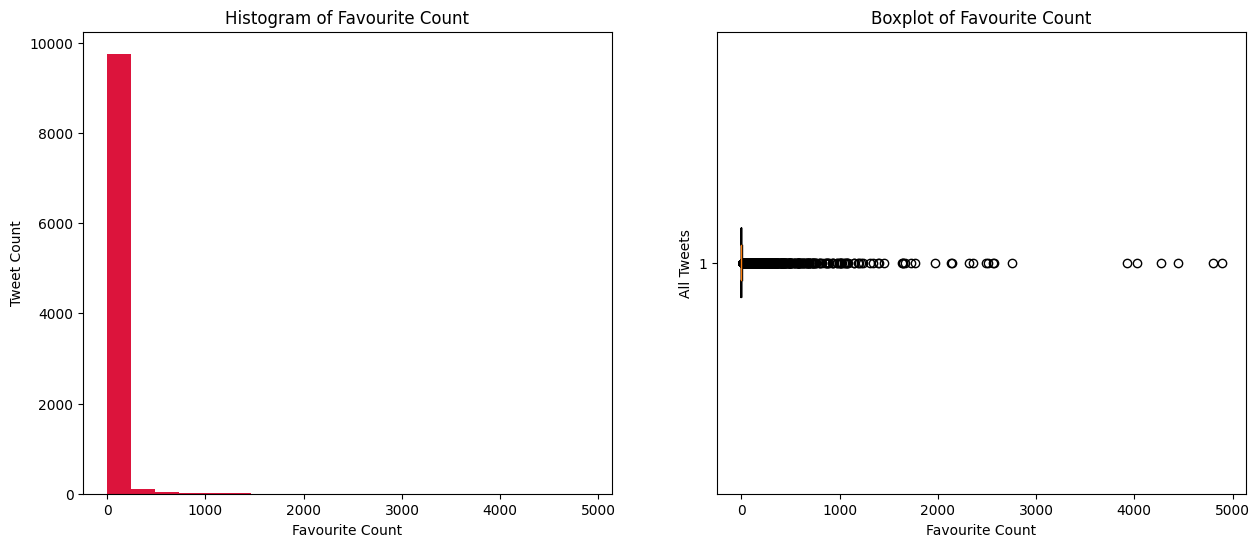

In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(15, 6))
ax[0].hist(df2.tweet_favourite_count, bins=20, color="crimson")
ax[1].boxplot(df2.tweet_favourite_count, notch=True, vert = False)
ax[0].set_title("Histogram of Favourite Count")
ax[1].set_title("Boxplot of Favourite Count")
ax[0].set_xlabel("Favourite Count")
ax[1].set_xlabel("Favourite Count")
ax[0].set_ylabel("Tweet Count")
ax[1].set_ylabel("All Tweets")
plt.show()

Removing the tweets with no likes, there is a marginal difference in our graphs, with largely the same shapes. We still have a very left skewed graph, implying that there is still a large number of tweets with a very low number of likes

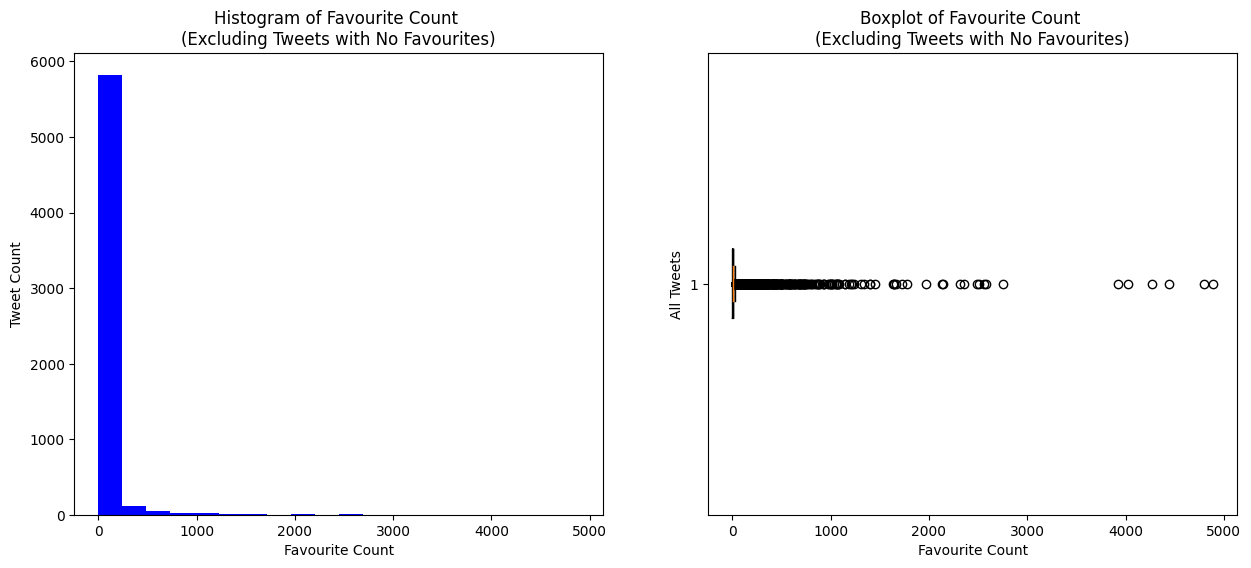

In [ ]:
# Excludes tweets with no favourites
fig, ax = plt.subplots(1, 2,figsize=(15, 6))
ax[0].hist(df2[df2["tweet_favourite_count"]>0].tweet_favourite_count, bins=20, color="blue")
ax[1].boxplot(df2[df2["tweet_favourite_count"]>0].tweet_favourite_count, notch=True, vert = False)
ax[0].set_title("Histogram of Favourite Count \n(Excluding Tweets with No Favourites)")
ax[1].set_title("Boxplot of Favourite Count \n(Excluding Tweets with No Favourites)")
ax[0].set_xlabel("Favourite Count")
ax[1].set_xlabel("Favourite Count")
ax[0].set_ylabel("Tweet Count")
ax[1].set_ylabel("All Tweets")
plt.show()

#### Retweet Count

In [ ]:
get_min_max(df2.tweet_retweet_count)

(0, 1562)

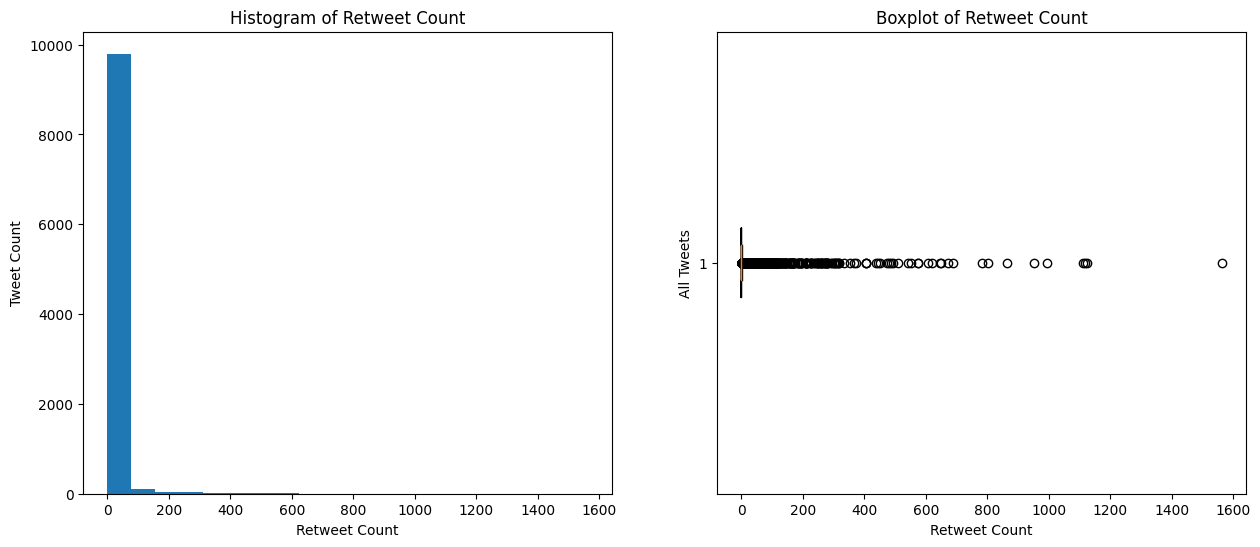

In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(15, 6))
ax[0].hist(df2.tweet_retweet_count, bins=20)
ax[1].boxplot(df2.tweet_retweet_count, notch=True, vert = False)
ax[0].set_title("Histogram of Retweet Count")
ax[1].set_title("Boxplot of Retweet Count")
ax[0].set_xlabel("Retweet Count")
ax[1].set_xlabel("Retweet Count")
ax[0].set_ylabel("Tweet Count")
ax[1].set_ylabel("All Tweets")
plt.show()

#### Engagement Rate

Since our model uses categorical outcomes, we need to find a way to threshold our existing reward variables into a categorical reward variable

In [ ]:
# In database, have 21 users with no followers
len(df2[df2["user_followers_count"] == 0])

0

In [ ]:
get_min_max(df2.engagement_rate)

(0.0, 5.823008849557522)

In [ ]:
# drop these users
df2.drop(df2.loc[df2['user_followers_count']==0].index, inplace=True)

In [ ]:
# column Engagement rate = # Number of likes / Number of Followers
df2["engagement_rate"] = (df2["tweet_favourite_count"] + df2["tweet_retweet_count"])/df2["user_followers_count"]

# column Engagement score = 1 or 0, this is if engagement rate > 0.01
df2["engagement_score"] = np.where(df2['engagement_rate']>= 0.01, 1, 0)

# lower engagement score threshold
df2["low_engagement_score"] = np.where(df2['engagement_rate']>= 0.001, 1, 0)

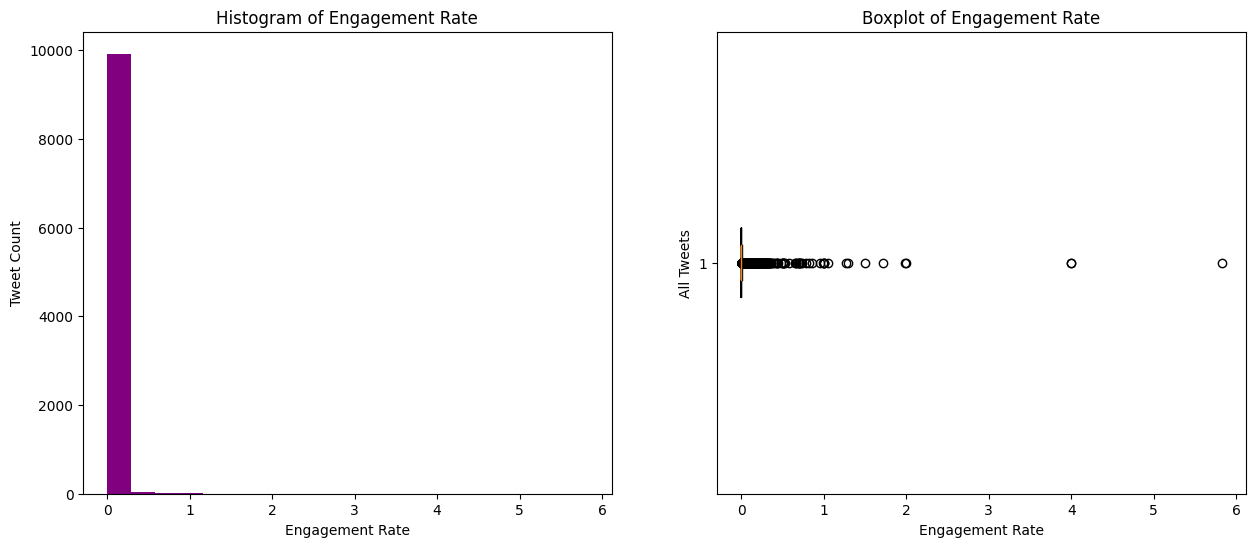

In [ ]:
fig, ax = plt.subplots(1, 2,figsize=(15, 6))
ax[0].hist(df2.engagement_rate, bins=20, color="purple")
ax[1].boxplot(df2.engagement_rate, notch=True, vert = False)
ax[0].set_title("Histogram of Engagement Rate")
ax[1].set_title("Boxplot of Engagement Rate")
ax[0].set_xlabel("Engagement Rate")
ax[1].set_xlabel("Engagement Rate")
ax[0].set_ylabel("Tweet Count")
ax[1].set_ylabel("All Tweets")
plt.show()

In [ ]:
df2.groupby("engagement_score").size()

engagement_score
0    8502
1    1477
dtype: int64

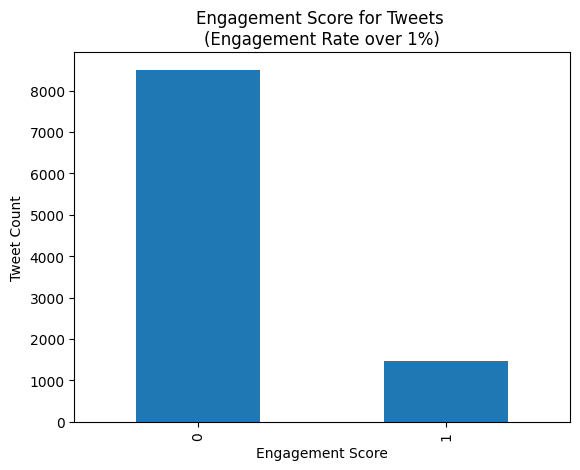

In [ ]:
df2.groupby("engagement_score").size().plot.bar()
plt.title("Engagement Score for Tweets \n(Engagement Rate over 1%)")
plt.xlabel("Engagement Score")
# plt.xticks(np.arange(2), ['Over 1%', 'Under 1%'])
plt.ylabel("Tweet Count")
plt.show()

In [ ]:
df2.groupby("engagement_score").count()

,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count,sentiment_score,sentiment,engagement_rate,low_engagement_score,tweet_created_timestamp,tweet_created_time,time_of_day,username_length,tokens,tweet_created_hour
engagement_score,,,,,,,,,,,,,,,,,
0,8502,8502,8502,8502,8502,8502,8502,8502,8502,8502,8502,8502,8502,8502,8502,8502,8502
1,1477,1477,1477,1477,1477,1477,1477,1477,1477,1477,1477,1477,1477,1477,1477,1477,1477


In [ ]:
8502/(8502+1477)

0.8519891772722717

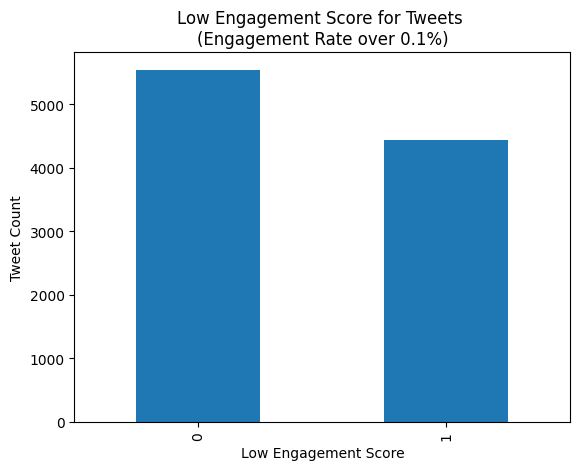

In [ ]:
df2.groupby("low_engagement_score").size().plot.bar()
plt.title("Low Engagement Score for Tweets \n(Engagement Rate over 0.1%)")
plt.xlabel("Low Engagement Score")
plt.ylabel("Tweet Count")
plt.show()

In [ ]:
df2.groupby("low_engagement_score").count()

,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count,sentiment_score,sentiment,engagement_rate,engagement_score,tweet_created_timestamp,tweet_created_time,time_of_day,username_length,tokens,tweet_created_hour
low_engagement_score,,,,,,,,,,,,,,,,,
0,5542,5542,5542,5542,5542,5542,5542,5542,5542,5542,5542,5542,5542,5542,5542,5542,5542
1,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437,4437


In [ ]:
5542/(5542+4437)

0.555366269165247

#### Creation Time

Creation Time is a string. Here, we will add a column converting it to a timestamp instead.

In [ ]:
type(df2["tweet_created_at"][0])

str

##### Created Timestamp

In [ ]:
from datetime import datetime
df2["tweet_created_timestamp"] = [datetime.fromisoformat(t) for t in df2["tweet_created_at"]]

In [ ]:
type(df2["tweet_created_timestamp"][0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
get_min_max(df2.tweet_created_timestamp)

(Timestamp('2023-03-23 18:54:46+0000', tz='UTC'),
 Timestamp('2023-03-27 21:01:36+0000', tz='UTC'))

From this, we can see that the date range of this data is from Thurs, March 23, 2023 at 6:54:46 pm to Monday, March 27, 2023, at 9:01:36pm UTC.

Since UTC is 4 hours ahead of EST, that would be around Thurs afternoon 3pm EST to Monday night 5pm EST.

This data spans 5 days. We can create another column, tweet created time, that specifies just the time of day that the tweet was created

##### Created Time, Created Hour

In [ ]:
df2['tweet_created_time'] = [datetime.time(d) for d in df2['tweet_created_timestamp']]

In [ ]:
df2['tweet_created_hour'] = [t.hour for t in df2.tweet_created_time]

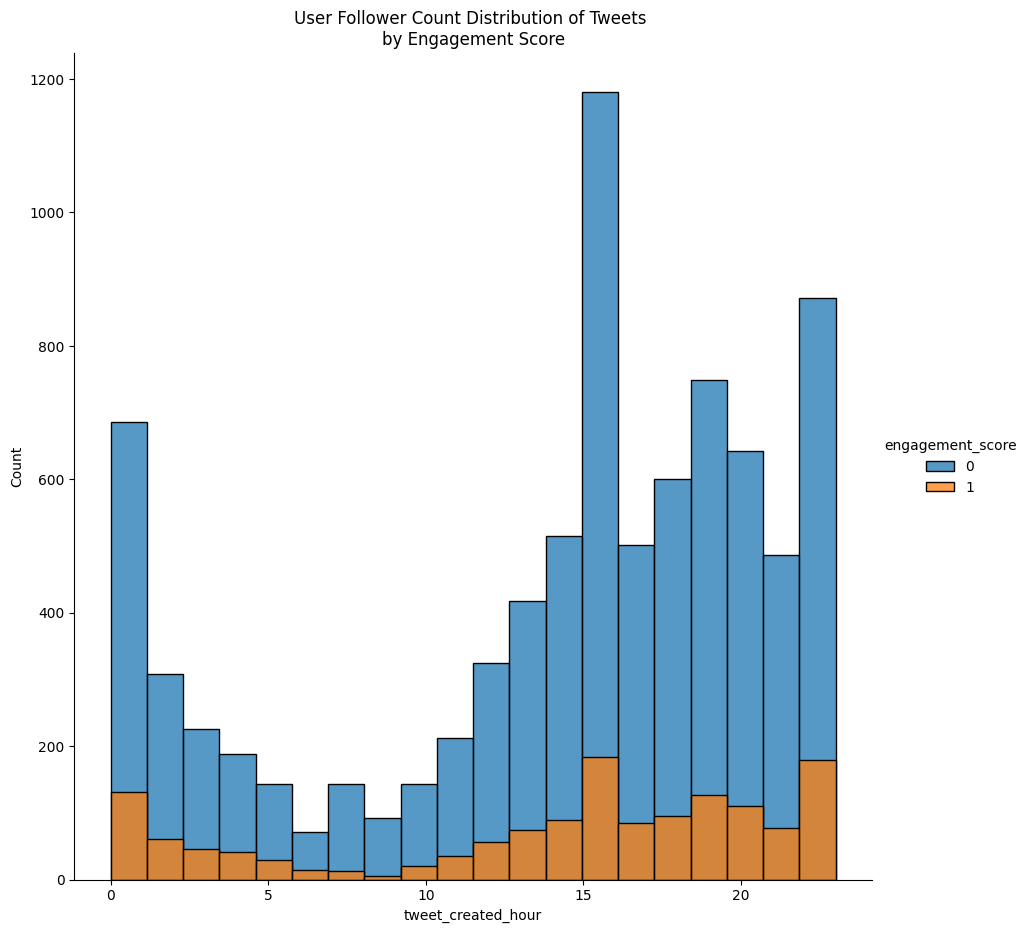

In [ ]:
sns.FacetGrid(df2, hue = "engagement_score", height=9).map(sns.histplot, "tweet_created_hour", bins=20).add_legend()
plt.title("User Follower Count Distribution of Tweets \nby Engagement Score")
plt.show()

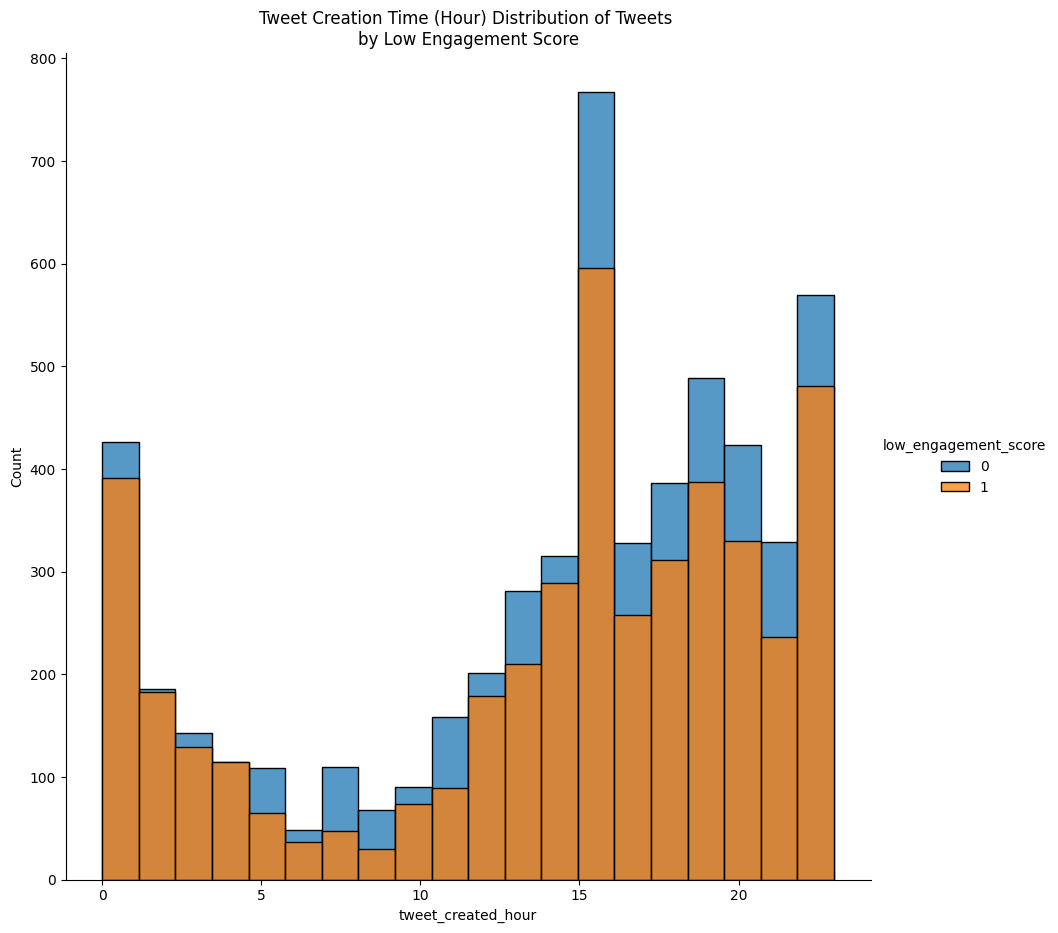

In [ ]:
sns.FacetGrid(df2, hue = "low_engagement_score", height=9).map(sns.histplot, "tweet_created_hour", bins=20).add_legend()
plt.title("Tweet Creation Time (Hour) Distribution of Tweets \nby Low Engagement Score")
plt.show()

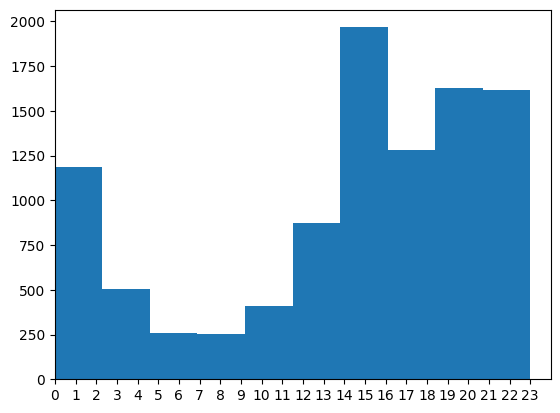

In [ ]:
numbers=[x for x in range(0,24)]
labels=map(lambda x: str(x), numbers)
plt.xticks(numbers, labels)
plt.xlim(0,24)
plt.hist(df2['tweet_created_hour'])
plt.show()

##### Created Time of Day

In [ ]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return (start <= x) & (x<= end)

    else:
        return (start <= x)|(x <= end)


Canadian politics tweet --> we assume canadians are tweeting EST and not UTC (which is the time zone this is tweeted in). So, EST 6pm is actually UTC 10pm.

In [ ]:
import datetime
df2.loc[(time_in_range(datetime.time(4, 0, 0), datetime.time(10, 0, 0), df2['tweet_created_time']), 'time_of_day')] = "Night \n(12am-6am EST)" #12am-6am EST
df2.loc[(time_in_range(datetime.time(10, 0, 0), datetime.time(16, 0, 0), df2['tweet_created_time']), 'time_of_day')] = "Morning \n(6am-12pm EST)"#6am-12pm EST
df2.loc[(time_in_range(datetime.time(16, 0, 0), datetime.time(22, 0, 0), df2['tweet_created_time']), 'time_of_day')] = "Afternoon \n(12pm-6pm EST)"#12pm-6pm EST
df2.loc[(time_in_range(datetime.time(22, 0, 0), datetime.time(4, 0, 0), df2['tweet_created_time']), 'time_of_day')] = "Evening \n(6pm-12am EST)"#6pm-12am EST

In [ ]:
time_of_day_order = ["Morning \n(6am-12pm EST)", "Afternoon \n(12pm-6pm EST)", "Evening \n(6pm-12am EST)", "Night \n(12am-6am EST)"]
sns.countplot(x = "time_of_day", data = df2, order = time_of_day_order)
plt.title("Time of Day of Tweet Creation")
plt.xlabel("Time of Day")
plt.ylabel("Tweet Count")
plt.show()

It looks like there is no one particular time of day where engagement score tends to be higher - they all have similar distributions

In [ ]:
df2['engagement_score'].hist(by=df2['time_of_day'])

In [ ]:
df2['low_engagement_score'].hist(by=df2['time_of_day'])

#### Tweet Text

In [ ]:
type(df2["tweet_text"][0])

str

#### User Statuses Count

In [ ]:
# Range of user statuses (ie. user status = total number of tweets/retweets for the user)
# We can see there is quite a wide distribution
get_min_max(df2.user_statuses_count)

(4, 1041619)

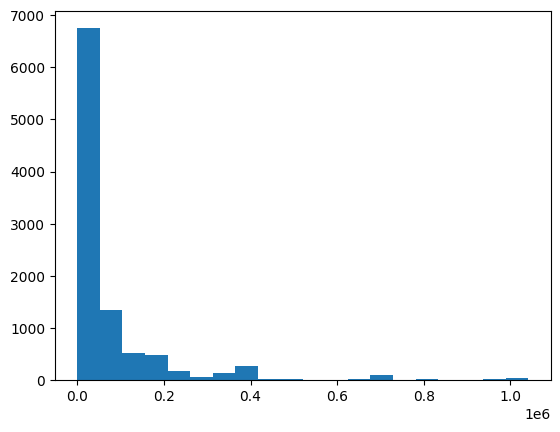

In [ ]:
# It is also quite right skewed
plt.hist(df2.user_statuses_count, bins=20)
plt.show()

It looks like user status count trend is similar for both of them. However, there are a few different peaks here and there which may be worth looking into

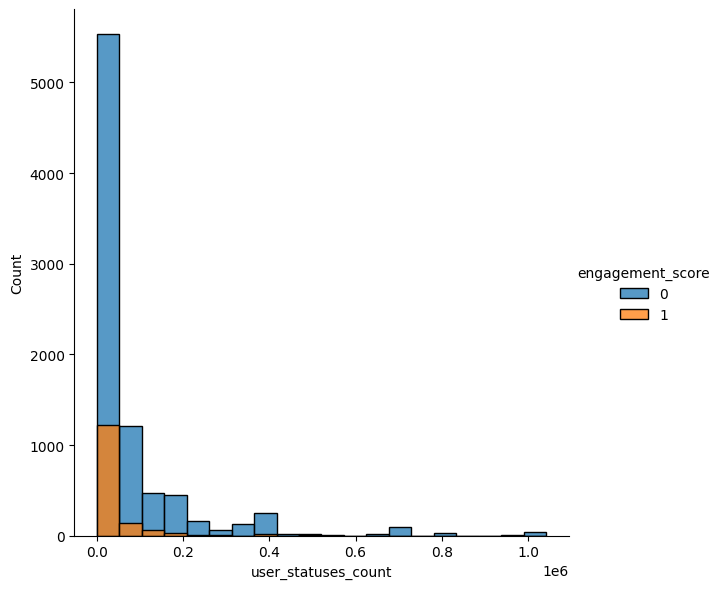

In [ ]:
# To determine if this might be a good feature to use, let's further group that by engagement score and see if there is a difference
sns.FacetGrid(df2, hue = "engagement_score", height=6).map(sns.histplot, "user_statuses_count", bins=20).add_legend()
plt.show()

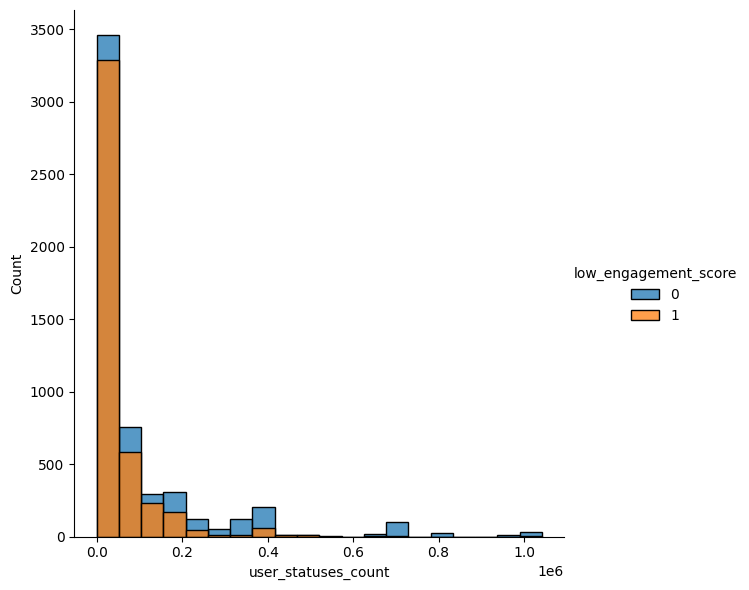

In [ ]:
sns.FacetGrid(df2, hue = "low_engagement_score", height=6).map(sns.histplot, "user_statuses_count", bins=20).add_legend()
plt.show()

#### User Username

In [ ]:
df2["username_length"] = [len(username) for username in df2.user_screen_name]

(array([ 149.,  253.,  468.,  796., 1021., 1150., 1020., 1432., 1393.,
        2297.]),
 array([ 4. ,  5.1,  6.2,  7.3,  8.4,  9.5, 10.6, 11.7, 12.8, 13.9, 15. ]),
 <BarContainer object of 10 artists>)

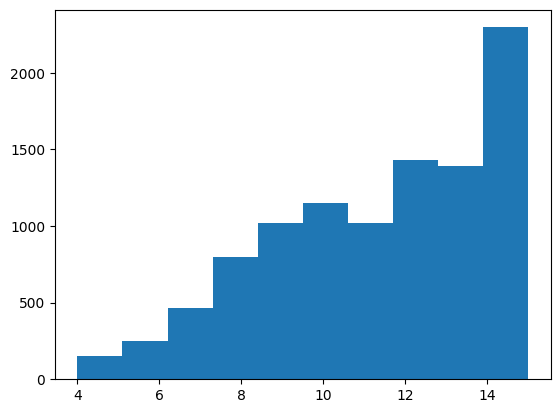

In [ ]:
plt.hist(df2.username_length)

Hard to tell, but there may be a bit of a change in username length between engagement scores, as seen by the dip at username length of 11 for engagement score of 0, and the increase for engagement score of 1.

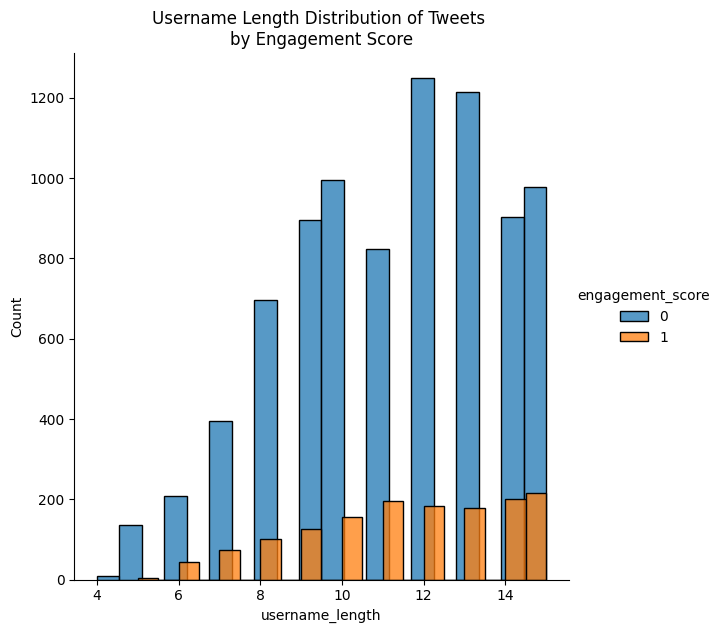

In [ ]:
sns.FacetGrid(df2, hue = "engagement_score", height=6).map(sns.histplot, "username_length", bins = 20).add_legend()
plt.title("Username Length Distribution of Tweets \nby Engagement Score")
plt.show()

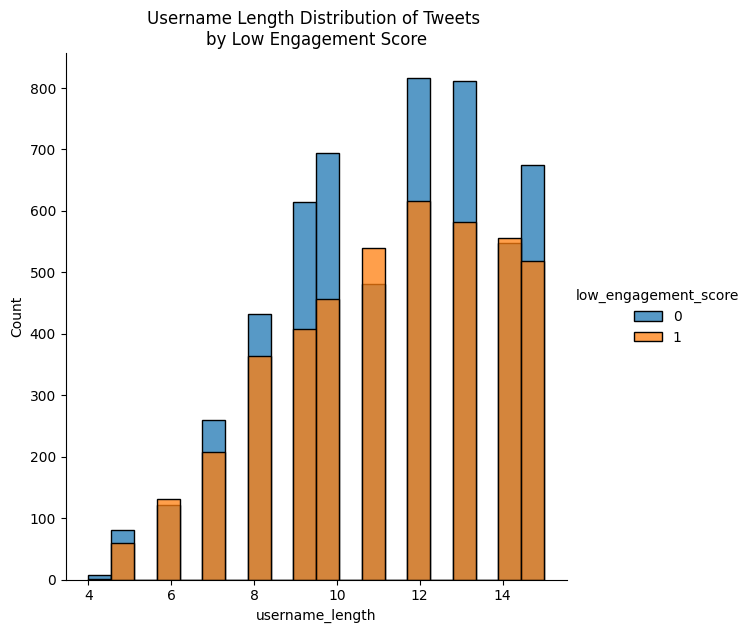

In [ ]:
sns.FacetGrid(df2, hue = "low_engagement_score", height=6).map(sns.histplot, "username_length", bins = 20).add_legend()
plt.title("Username Length Distribution of Tweets \nby Low Engagement Score")
plt.show()

#### User Followers

(array([9.792e+03, 1.060e+02, 5.300e+01, 8.000e+00, 6.000e+00, 1.000e+01,
        3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.000000e+00, 7.552120e+04, 1.510414e+05, 2.265616e+05,
        3.020818e+05, 3.776020e+05, 4.531222e+05, 5.286424e+05,
        6.041626e+05, 6.796828e+05, 7.552030e+05]),
 <BarContainer object of 10 artists>)

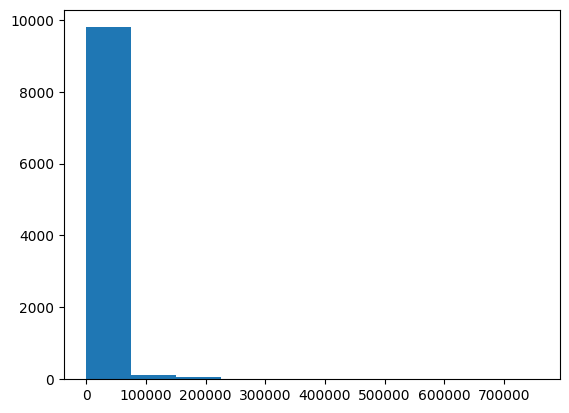

In [ ]:
plt.hist(df2["user_followers_count"])

The dataset is very unbalanced, but it looks like the overall trend is the same. However, there may be some difference within the smaller interval that could be useful as a feature.

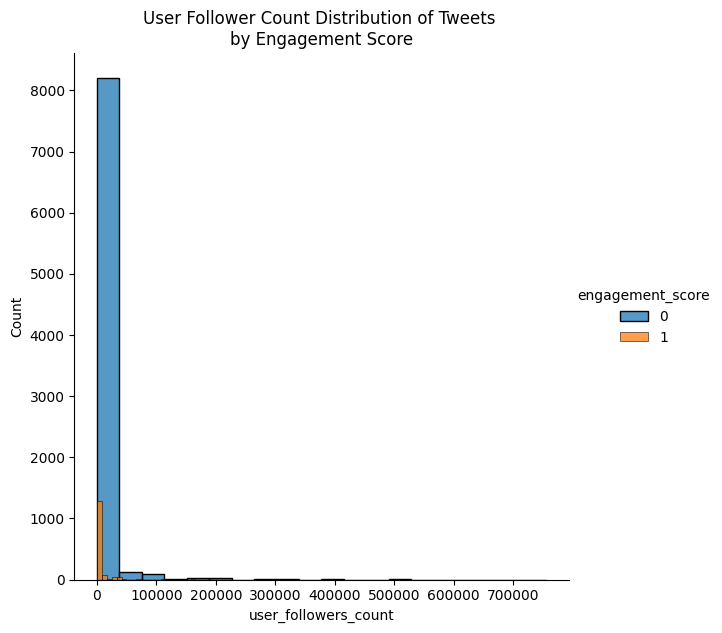

In [ ]:
sns.FacetGrid(df2, hue = "engagement_score", height=6).map(sns.histplot, "user_followers_count", bins=20).add_legend()
plt.title("User Follower Count Distribution of Tweets \nby Engagement Score")
plt.show()

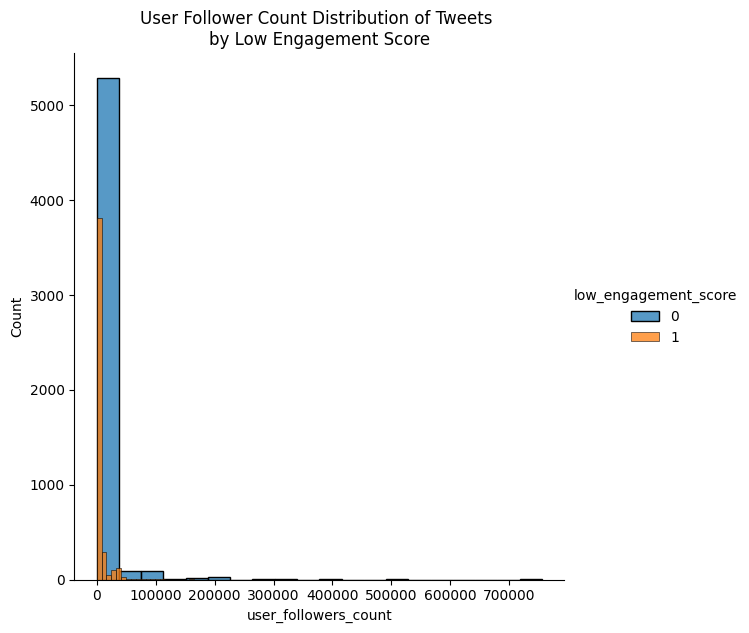

In [ ]:
sns.FacetGrid(df2, hue = "low_engagement_score", height=6).map(sns.histplot, "user_followers_count", bins=20).add_legend()
plt.title("User Follower Count Distribution of Tweets \nby Low Engagement Score")
plt.show()

#### Sentiment

(array([  51.,  183.,  287.,  338.,  498.,  475.,  612.,  316.,  292.,
         168., 3316.,  283.,  337.,  571.,  745.,  453.,  437.,  329.,
         216.,   72.]),
 array([-0.9714 , -0.87448, -0.77756, -0.68064, -0.58372, -0.4868 ,
        -0.38988, -0.29296, -0.19604, -0.09912, -0.0022 ,  0.09472,
         0.19164,  0.28856,  0.38548,  0.4824 ,  0.57932,  0.67624,
         0.77316,  0.87008,  0.967  ]),
 <BarContainer object of 20 artists>)

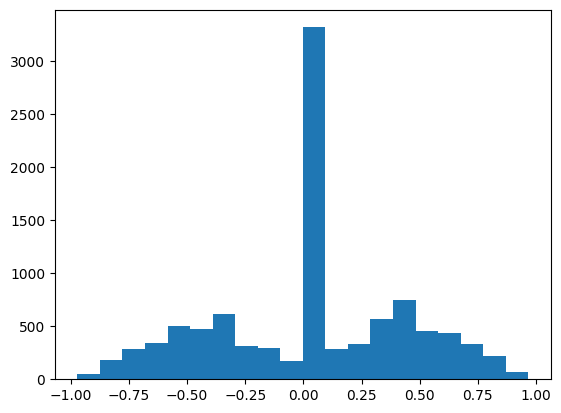

In [ ]:
# Distribution of sentiment score: it seems more balanced, with majority of tweets being neural
plt.hist(df2.sentiment_score, bins=20)

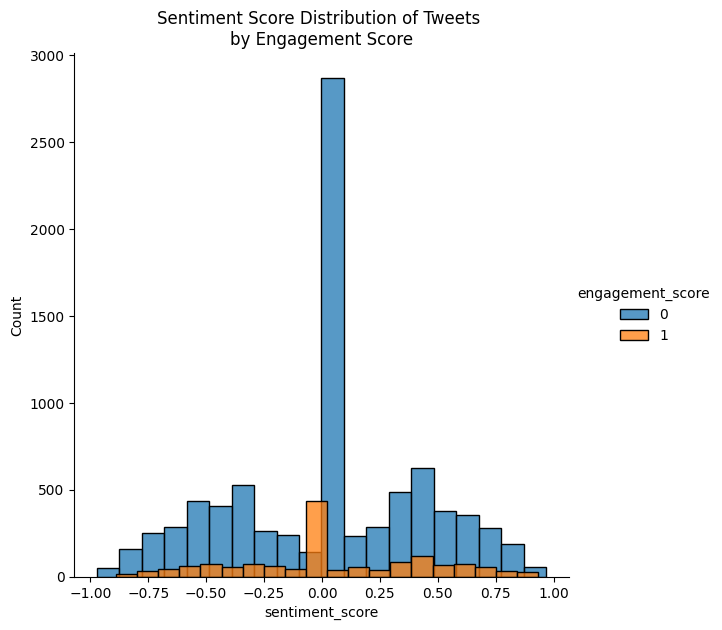

In [ ]:
sns.FacetGrid(df2, hue = "engagement_score", height=6).map(sns.histplot, "sentiment_score", bins = 20).add_legend()
plt.title("Sentiment Score Distribution of Tweets \nby Engagement Score")
plt.show()

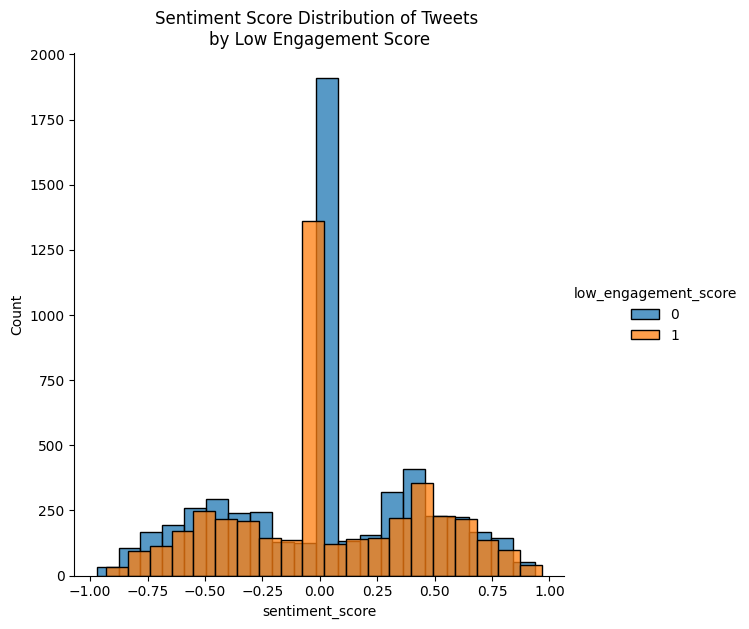

In [ ]:
sns.FacetGrid(df2, hue = "low_engagement_score", height=6).map(sns.histplot, "sentiment_score", bins = 20).add_legend()
plt.title("Sentiment Score Distribution of Tweets \nby Low Engagement Score")
plt.show()

### Correlations

In [ ]:
df2.describe()

,tweet_favourite_count,tweet_retweet_count,user_statuses_count,user_followers_count,sentiment_score,engagement_rate,engagement_score,low_engagement_score,username_length
count,9979.000000,9979.000000,9.979000e+03,9979.000000,9979.000000,9979.000000,9979.000000,9979.000000,9979.000000
mean,25.642650,7.465277,7.550372e+04,7768.803688,0.021947,0.012246,0.148011,0.444634,11.268865
std,164.023273,46.920264,1.365482e+05,27829.184366,0.409868,0.102247,0.355129,0.496950,2.591397
min,0.000000,0.000000,4.000000e+00,1.000000,-0.971400,0.000000,0.000000,0.000000,4.000000
25%,0.000000,0.000000,8.757000e+03,462.000000,-0.273200,0.000000,0.000000,0.000000,9.000000
50%,1.000000,0.000000,2.845000e+04,1350.000000,0.000000,0.000630,0.000000,0.000000,12.000000
75%,5.000000,2.000000,6.686200e+04,4521.000000,0.361200,0.004217,0.000000,1.000000,13.000000
max,4889.000000,1562.000000,1.041619e+06,755203.000000,0.967000,5.823009,1.000000,1.000000,15.000000


<ipython-input-377-5960e8ac5119>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df2.corr(), annot = True)


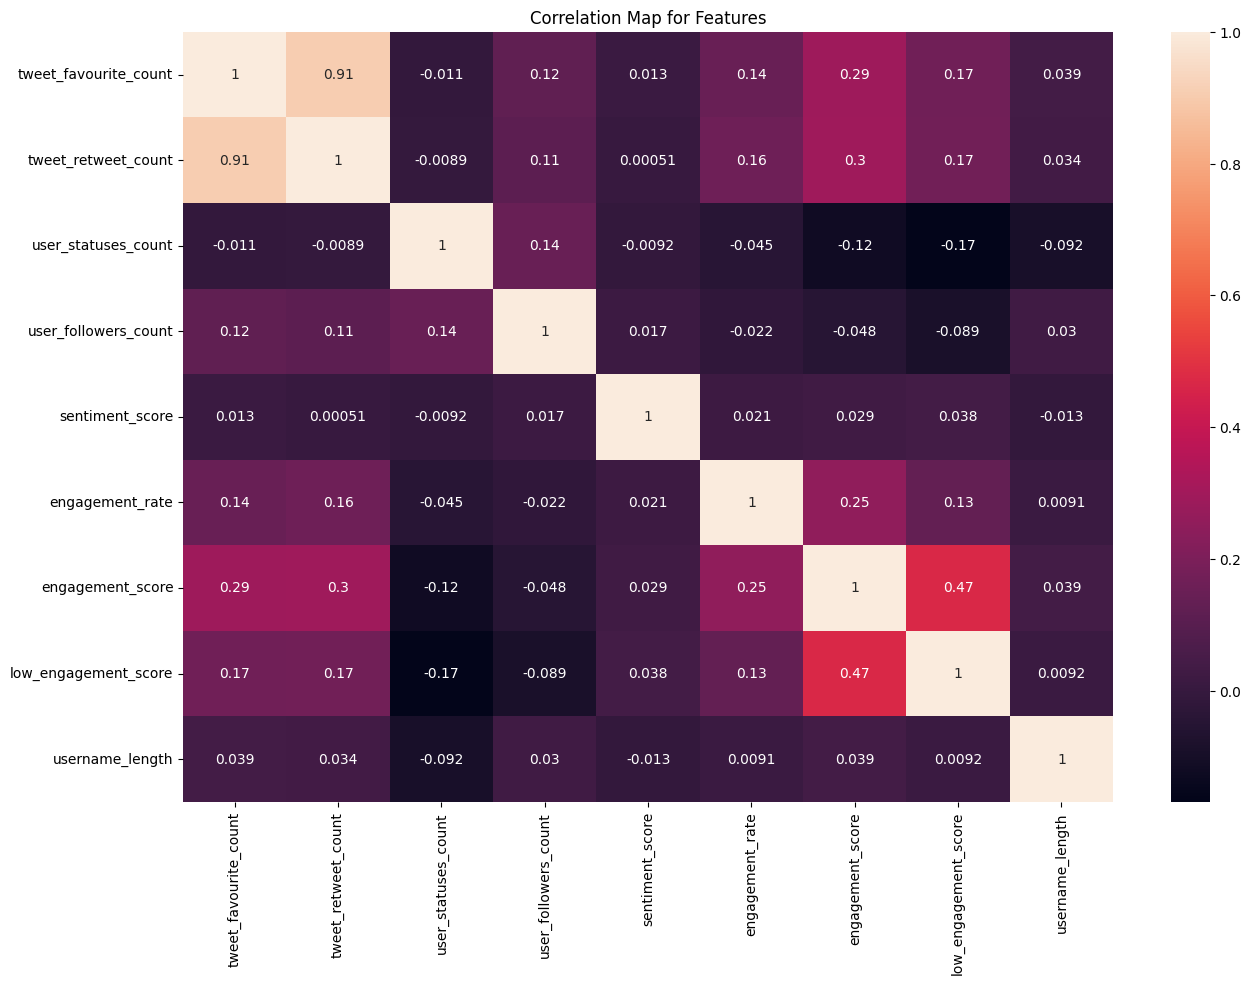

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df2.corr(), annot = True)
plt.title("Correlation Map for Features")
plt.show()

In [ ]:
# Correlation between text length, likes, and retweets
# sns.pairplot(data=df2)

## ML Model

###Preprocessing: TF-IDF Vectors


In [ ]:
tokenize(df2, 'tweet_text')
remove_url(df2)
convert_lowercase(df2)
remove_punctuation(df2)
stem_tokens(df2)
remove_stopwords(df2)

In [ ]:
# train and test splits
train_df2, test_df2 = train_test_split(df2, train_size = 0.7)

In [ ]:
# Keep original doc numbers as "index" column, and reset the indices for the individual test and training datasets
train_df2=train_df2.reset_index()
test_df2=test_df2.reset_index()

In [ ]:
train_df2

,index,tweet_text,tweet_favourite_count,tweet_created_at,tweet_retweet_count,user_statuses_count,user_screen_name,user_followers_count,sentiment_score,sentiment,engagement_rate,engagement_score,low_engagement_score,tweet_created_timestamp,tweet_created_time,time_of_day,username_length,tokens
0,741,@RhiHoyleYEG @Frazzling @RachelNotley is @rach...,0,2023-03-27 16:09:16+00:00,0,29887,Robert_MacKay_,267,-0.2263,0,0.000000,0,0,2023-03-27 16:09:16+00:00,16:09:16,Afternoon \n(12pm-6pm EST),14,"[rhihoyleyeg, frazzl, rachelnotley, rachelnotl..."
1,3877,Petulant Alberta Conservatives are not fit to ...,12,2023-03-25 21:40:57+00:00,4,75341,micropainter,1405,-0.2755,0,0.011388,1,1,2023-03-25 21:40:57+00:00,21:40:57,Afternoon \n(12pm-6pm EST),12,"[petul, alberta, conserv, not, fit, repres, th..."
2,7109,@HarvardBiz @reshiftmedia hired Shambhavi Anan...,0,2023-03-24 17:32:13+00:00,0,17614,shamnis9182,380,-0.4215,0,0.000000,0,0,2023-03-24 17:32:13+00:00,17:32:13,Afternoon \n(12pm-6pm EST),11,"[harvardbiz, reshiftmedia, hire, shambhavi, an..."
3,3199,@mikethenavyguy laying the foundation for some...,1,2023-03-26 11:16:05+00:00,0,44804,jtispoindexter,812,0.3612,2,0.001232,0,1,2023-03-26 11:16:05+00:00,11:16:05,Morning \n(6am-12pm EST),14,"[mikethenavyguy, lay, foundat, some, trickl, b..."
4,2136,"1/ ""Yesterday in Auckland the British womenâ...",1,2023-03-26 21:24:28+00:00,1,27814,SplendidIsolat2,1681,0.0000,1,0.001190,0,1,2023-03-26 21:24:28+00:00,21:24:28,Afternoon \n(12pm-6pm EST),15,"[1, yesterday, auckland, british, womenâ, righ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6980,8934,Banks about to go digital brace your self #cdn...,0,2023-03-24 00:44:47+00:00,0,20806,LucianoT1977,114,0.0000,1,0.000000,0,0,2023-03-24 00:44:47+00:00,00:44:47,Evening \n(6pm-12am EST),12,"[bank, go, digit, brace, self, cdnpoli, justin..."
6981,4457,#BREAKING - Premier @fordnation will no longer...,0,2023-03-25 17:01:14+00:00,0,34,voters_house,6,-0.3818,0,0.000000,0,0,2023-03-25 17:01:14+00:00,17:01:14,Afternoon \n(12pm-6pm EST),12,"[break, , premier, fordnat, will, no, longer, ..."
6982,9085,AKA how to get a slum built in no time. @Pierr...,0,2023-03-23 23:34:48+00:00,0,144655,sarmcbride,1520,-0.2960,0,0.000000,0,0,2023-03-23 23:34:48+00:00,23:34:48,Evening \n(6pm-12am EST),10,"[aka, how, get, slum, built, no, time, pierrep..."
6983,6463,#FEWO @HoCCommittees shitshow : inviting anti-...,12,2023-03-24 20:17:21+00:00,8,19323,CDNSWAlliance,11241,0.1779,2,0.001779,0,1,2023-03-24 20:17:21+00:00,20:17:21,Afternoon \n(12pm-6pm EST),13,"[fewo, hoccommitte, shitshow, , invit, antitra..."


In [ ]:
# 6985 tweets and 19 columns for training set
np.shape(train_df2)

(6985, 18)

In [ ]:
np.shape(test_df2)

(2994, 18)

In [ ]:
# TF-IDF
train_counts= convert_to_counts(train_df2)
test_counts = convert_to_counts(test_df2)
train_vectors = convert_to_tfidf(train_counts)
test_vectors = convert_to_tfidf(test_counts)

In [ ]:
# 6985 tweets and 1000 words for training set
np.shape(train_vectors)

(6985, 1000)

In [ ]:
np.shape(test_vectors)

(2994, 1000)

### Preprocessing: Make Features Array

Combine the word vectors with other features (ie. sentiment score, user follower count, etc.)

In [ ]:
def make_feature_arrays(other_features):
  ''' Returns X_train (feature array for training dataset), and X_test (testing dataset)'''
  df2_X_train = train_df2[other_features].copy()
  df2_X_train = pd.concat([df2_X_train, pd.DataFrame(train_vectors, columns=[find_key(count_vec.vocabulary_, i) for i in range(1000)])], axis=1)

  df2_X_test = test_df2[other_features].copy()
  df2_X_test = pd.concat([df2_X_test, pd.DataFrame(test_vectors, columns=[find_key(count_vec.vocabulary_, i) for i in range(1000)])], axis=1)
  return df2_X_train.values, df2_X_test.values

##### Experimenting

In [ ]:
# Below is experimenting to come up with function above
df2_X_train = train_df2[["sentiment_score"]].copy()

In [ ]:
df2_X_train

,sentiment_score
0,-0.2263
1,-0.2755
2,-0.4215
3,0.3612
4,0.0000
...,...
6980,0.0000
6981,-0.3818
6982,-0.2960
6983,0.1779


In [ ]:
# Recall: vocabulary dictionary keys are the words, values are the index of the word
count_vec.vocabulary_["hi"]

407

In [ ]:
# We want to get the word with the index (ie. get key from value)
def find_key(input_dict, value):
    for key, val in input_dict.items():
        if val == value: return key
    return "None"

In [ ]:
find_key(count_vec.vocabulary_, 407)

'hi'

In [ ]:
# TF-IDF Vectors: each column is a word, then each row is the tweet/doc
tfidf_df2 = pd.DataFrame(train_vectors, columns=[find_key(count_vec.vocabulary_, i) for i in range(1000)])
tfidf_df2

,,1,10,100,15,2,2021,2023,24,3,...,youâr,yr,yvrre,â,âthe,âï,ð,ðð,ðð³abort,ððð
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35178,0.0
3,0.491688,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,0.000000,0.415414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6980,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
6981,0.174281,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
6982,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
6983,0.287348,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


In [ ]:
df_X_train = pd.concat([df2_X_train, tfidf_df2], axis=1)

In [ ]:
# Looks right! Our combined features: word vectors and also other features
df_X_train

,sentiment_score,,1,10,100,15,2,2021,2023,24,...,youâr,yr,yvrre,â,âthe,âï,ð,ðð,ðð³abort,ððð
0,-0.2263,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,-0.2755,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,-0.4215,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35178,0.0
3,0.3612,0.491688,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,0.0000,0.000000,0.415414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6980,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
6981,-0.3818,0.174281,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
6982,-0.2960,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
6983,0.1779,0.287348,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


In [ ]:
# Format we will use to actually train the model
df_X_train.values

array([[-0.2263    ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2755    ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.4215    ,  0.        ,  0.        , ...,  0.        ,
         0.35178011,  0.        ],
       ...,
       [-0.296     ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1779    ,  0.28734766,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4019    ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
# Repeat for testing dataset
df2_X_test = test_df2[["sentiment_score"]].copy()
df_X_test = pd.concat([df2_X_test, pd.DataFrame(test_vectors, columns=[find_key(count_vec.vocabulary_, i) for i in range(1000)])], axis=1)

### Logistic Regression

#### Model 1: Just Word TFIDF Vectors

In [ ]:
# Engagement Score
log_reg= LogisticRegression()
log_reg.fit(train_vectors, train_df2['engagement_score'])
y_preds = log_reg.predict(test_vectors)
y_preds_train = log_reg.predict(train_vectors)

print('Test accuracy with simple Logistic Regression on training data:',accuracy_score(train_df2['engagement_score'], y_preds_train))
print('Test accuracy with simple Logistic Regression on testing data:',accuracy_score(test_df2['engagement_score'], y_preds))
cf_matrix = confusion_matrix(test_df2['engagement_score'], y_preds)
print(cf_matrix)

Test accuracy with simple Logistic Regression on training data: 0.8539727988546886
Test accuracy with simple Logistic Regression on testing data: 0.8483633934535738
[[2540    1]
 [ 453    0]]


In [ ]:
# Low Engagement Score
log_reg_low= LogisticRegression()
log_reg_low.fit(train_vectors, train_df2['low_engagement_score'])
y_preds_low = log_reg_low.predict(test_vectors)
y_preds_train_low = log_reg_low.predict(train_vectors)

# Accuracy
print('Test accuracy with simple Logistic Regression on training data:',accuracy_score(train_df2['engagement_score'], y_preds_train_low))
print('Test accuracy with simple Logistic Regression on testing data:',accuracy_score(test_df2['engagement_score'], y_preds_low))
cf_matrix_low = confusion_matrix(test_df2['engagement_score'], y_preds_low)
cf_matrix_low

Test accuracy with simple Logistic Regression on training data: 0.6735862562634216
Test accuracy with simple Logistic Regression on testing data: 0.6696726786907148


array([[1880,  661],
       [ 328,  125]])

#### Model 2: Word TFIDF + Sentiment Score

In [ ]:
X_train1, X_test1 = make_feature_arrays(["sentiment_score"])

In [ ]:
# Engagement Score
log_reg1 = LogisticRegression()
log_reg1.fit(X_train1, train_df2['engagement_score'])

y_preds1 = log_reg1.predict(X_test1)
y_preds1_train = log_reg1.predict(X_train1)

# evaluate
print('Test accuracy with simple Logistic Regression on training data:',accuracy_score(train_df2['engagement_score'], y_preds1_train))
print('Test accuracy with simple Logistic Regression on testing data:',accuracy_score(test_df2['engagement_score'], y_preds1))
cf_matrix1 = confusion_matrix(test_df2['engagement_score'], y_preds1)
print(cf_matrix1)

Test accuracy with simple Logistic Regression on training data: 0.8538296349319972
Test accuracy with simple Logistic Regression on testing data: 0.8483633934535738
[[2540    1]
 [ 453    0]]


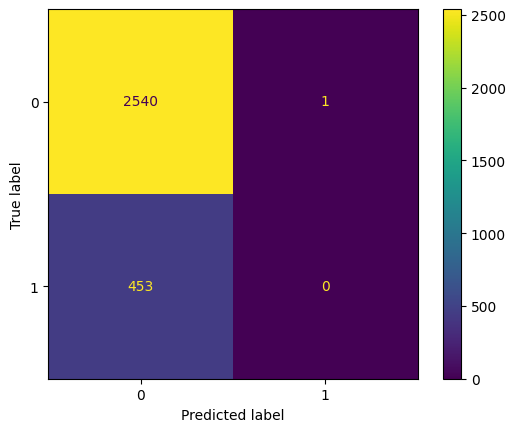

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix1, display_labels=log_reg1.classes_)
disp.plot()
plt.show()

In [ ]:
# Low Engagement Score
log_reg1_low= LogisticRegression()
log_reg1_low.fit(X_train1, train_df2['low_engagement_score'])

y_preds1_low = log_reg1_low.predict(X_test1)
y_preds1_train_low = log_reg1_low.predict(X_train1)

# evaluate
print('Test accuracy with simple Logistic Regression on training data:',accuracy_score(train_df2['engagement_score'], y_preds1_train_low))
print('Test accuracy with simple Logistic Regression on testing data:',accuracy_score(test_df2['engagement_score'], y_preds1_low))
cf_matrix1_low = confusion_matrix(test_df2['engagement_score'], y_preds1_low)
print(cf_matrix1_low)

Test accuracy with simple Logistic Regression on training data: 0.6730136005726557
Test accuracy with simple Logistic Regression on testing data: 0.6673346693386774
[[1874  667]
 [ 329  124]]


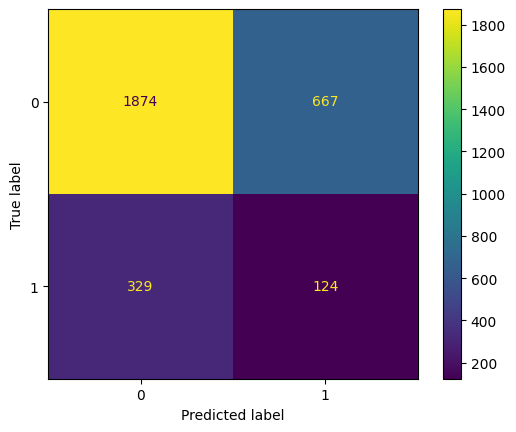

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix1_low, display_labels=log_reg1_low.classes_)
disp.plot()
plt.show()

#### Model 3: Word TFIDF + Username Length

In [ ]:
X_train2, X_test2 = make_feature_arrays(["username_length"])

In [ ]:
np.shape(X_train2)

(6985, 1001)

In [ ]:
# Engagement Score
log_reg2 = LogisticRegression()
log_reg2.fit(X_train2, train_df2['engagement_score'])

y_preds2 = log_reg2.predict(X_test2)
y_preds2_train = log_reg2.predict(X_train2)

# evaluate
print('Test accuracy with simple Logistic Regression on training data:',accuracy_score(train_df2['engagement_score'], y_preds2_train))
print('Test accuracy with simple Logistic Regression on testing data:',accuracy_score(test_df2['engagement_score'], y_preds2))
cf_matrix2 = confusion_matrix(test_df2['engagement_score'], y_preds2)
print(cf_matrix2)

Test accuracy with simple Logistic Regression on training data: 0.8534001431639227
Test accuracy with simple Logistic Regression on testing data: 0.8486973947895792
[[2541    0]
 [ 453    0]]


In [ ]:
# Low Engagement Score
log_reg2_low= LogisticRegression()
log_reg2_low.fit(X_train2, train_df2['low_engagement_score'])

y_preds2_low = log_reg2_low.predict(X_test2)
y_preds2_train_low = log_reg2_low.predict(X_train2)

# evaluate
print('Test accuracy with simple Logistic Regression on training data:',accuracy_score(train_df2['engagement_score'], y_preds2_train_low))
print('Test accuracy with simple Logistic Regression on testing data:',accuracy_score(test_df2['engagement_score'], y_preds2_low))
cf_matrix2_low = confusion_matrix(test_df2['engagement_score'], y_preds2_low)
print(cf_matrix2_low)

Test accuracy with simple Logistic Regression on training data: 0.8534001431639227
Test accuracy with simple Logistic Regression on testing data: 0.8486973947895792
[[2541    0]
 [ 453    0]]


#### Choosing a Model

To speed up the process of comparing different combinations of other features

##### Function (Test Logreg Model)

In [ ]:
def test_logreg_model(other_features):
  X_train, X_test = make_feature_arrays(other_features)
  # Engagement Score
  log_reg = LogisticRegression(max_iter=1000)
  log_reg.fit(X_train, train_df2['engagement_score']) # Fit on training data

  y_preds_train = log_reg.predict(X_train) # Predictions for training features
  y_preds = log_reg.predict(X_test) # Predictions for testing features

  print("-----Engagement Score-----")
  print('Test accuracy on training data:',accuracy_score(train_df2['engagement_score'], y_preds_train))
  print('Test accuracy on testing data:',accuracy_score(test_df2['engagement_score'], y_preds))
  cf_matrix = confusion_matrix(test_df2['engagement_score'], y_preds)
  print(cf_matrix)

  # Low Engagement Score
  log_reg_low= LogisticRegression()
  log_reg_low.fit(X_train, train_df2['low_engagement_score'])

  y_preds_train_low = log_reg_low.predict(X_train)
  y_preds_low = log_reg_low.predict(X_test)

  print("-----Low Engagement Score-----")
  print('Test accuracy on training data:',accuracy_score(train_df2['engagement_score'], y_preds_train_low))
  print('Test accuracy on testing data:',accuracy_score(test_df2['engagement_score'], y_preds_low))
  cf_matrix_low = confusion_matrix(test_df2['engagement_score'], y_preds_low)
  print(cf_matrix_low)

  return log_reg, cf_matrix, cf_matrix_low

##### Testing

In [ ]:
test_logreg_model(["sentiment_score"])

-----Engagement Score-----
Test accuracy on training data: 0.8538296349319972
Test accuracy on testing data: 0.8483633934535738
[[2540    1]
 [ 453    0]]
-----Low Engagement Score-----
Test accuracy on training data: 0.6730136005726557
Test accuracy on testing data: 0.6673346693386774
[[1874  667]
 [ 329  124]]


In [ ]:
test_logreg_model(["username_length"])

-----Engagement Score-----
Test accuracy on training data: 0.8539727988546886
Test accuracy on testing data: 0.8483633934535738
[[2540    1]
 [ 453    0]]
-----Low Engagement Score-----
Test accuracy on training data: 0.675161059413028
Test accuracy on testing data: 0.6710086840347361
[[1881  660]
 [ 325  128]]


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



## Final Model

In [ ]:
logreg, cf, cf_low=test_logreg_model(["sentiment_score", "username_length"])

-----Engagement Score-----
Test accuracy on training data: 0.8539727988546886
Test accuracy on testing data: 0.8483633934535738
[[2540    1]
 [ 453    0]]
-----Low Engagement Score-----
Test accuracy on training data: 0.6741589119541875
Test accuracy on testing data: 0.6663326653306614
[[1869  672]
 [ 327  126]]


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


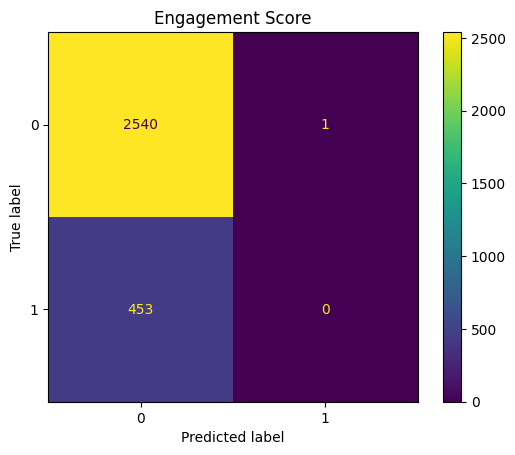

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=logreg.classes_)
disp.plot()
plt.title("Engagement Score")
plt.show()

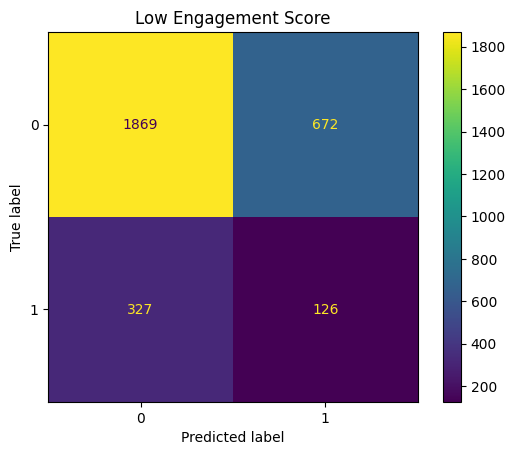

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cf_low, display_labels=log_reg.classes_)
disp.plot()
plt.title("Low Engagement Score")
plt.show()

### Naive Bayes

In [ ]:
# Did not end up using this

In [ ]:
nb = MultinomialNB()
nb.fit(train_vectors, train_df2['engagement_score'])

y_preds = nb.predict(test_vectors)
y_preds_train = nb.predict(train_vectors)

In [ ]:
# Accuracy
print('Test accuracy with simple Logistic Regression on training data:',accuracy_score(train_df2['engagement_score'], y_preds_train))
print('Test accuracy with simple Logistic Regression on testing data:',accuracy_score(test_df2['engagement_score'], y_preds))

Test accuracy with simple Logistic Regression on training data: 0.8534001431639227
Test accuracy with simple Logistic Regression on testing data: 0.8486973947895792


In [ ]:
cf_matrix1_low = confusion_matrix(test_df2['engagement_score'], y_preds)
cf_matrix1_low

array([[2541,    0],
       [ 453,    0]])